In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

print('PyTorch version:', torch.__version__)
print('torchvision verseion:', torchvision.__version__)
print('Is GPU avaibale:', torch.cuda.is_available())

PyTorch version: 1.0.0
torchvision verseion: 0.2.1
Is GPU avaibale: True


In [3]:
# settings
batchsize = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# データセットの準備
# Tensorにしつつ、 (-1 ~ 1)の範囲に正規化
tf = transforms.Compose([transforms.ToTensor(), 
                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# データセットをロード
# 本当はtraining data, validation data, test dataに分けるべきだが、今回は簡便のため2つに分ける.
mnist_train = datasets.MNIST(root = '../../data/MNIST',
                                 train = True,
                                 transform = tf,
                                 download = False)
mnist_validation = datasets.MNIST(root = '../../data/MNIST',
                                      train = False,
                                      transform = tf)

mnist_train_loader = DataLoader(mnist_train, batch_size = batchsize, shuffle = True)
mnist_validation_loader = DataLoader(mnist_validation, batch_size = batchsize, shuffle = True)

print('the number of training data', len(mnist_train))
print('the number of validation data', len(mnist_validation))

the number of training data 60000
the number of validation data 10000


torch.Size([1, 28, 28])


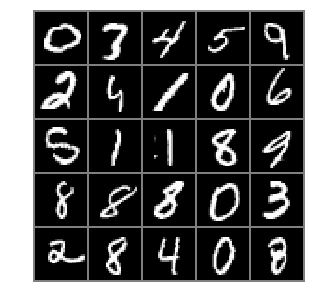

In [9]:
def imshow(img):
    npimg = img.numpy() * 0.5 + 0.5
    plt.figure(figsize = (5, 5))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
images, labels = iter(mnist_train_loader).next()
imshow(make_grid(images[:25], nrow=5, padding=1))
print(images[0].size())

In [13]:
class Invertible1x1Conv(nn.Module):
    def __init__(self, c):
        super(Invertible1x1Conv, self).__init__()
        
    def forward(self, z, reverse=False):
        1+1

In [14]:
class NN(nn.Module):
    def __init__(self, n_in_channels):
        super(NN, self).__init__()
    def forward(self, forward_input):
        1+1

In [20]:
class GlowAffineCoupling(nn.Module):
    def __init__(self, n_flows, n_group, n_early_every, n_earlysize):
        super(Glow, self).__init__()
        
        assert(n_group % 2 == 0)
        self.n_flows = n_flows
        self.n_group = n_group
        self.n_per_group = None
        self.n_early_every = n_early_every
        self.n_early_size = n_early_size
        
        self.NN = torch.nn.ModuleList()
        self.convinv = torch.nn.ModuleList()
        
        n_half = int(n_groups/2)
        
        n_remaining_channles = n_group
        for k in range(n_flows):
            if k % self.n_early_every == 0 and k > 0:
                n_half = n_half - int(self.n_early_size/2)
                n_remaining_channels = n_remaining_channels - self.n_early_size
            self.convinv.append(Invertible1x1Conv(n_remaining_channels))
            self.NN.append(NN(n_half))
        self.n_remaining_channels = n_remaining_channels
        
    def forward(self, forward_input):
        assert(forward_input.size(1) % self.n_group == 0)
        self.n_per_group = int(forward_input.size(1) / self.n_group)
        
        image = forward_input.unfold(1, self.n_group, self.n_group).permute(0, 2, 1)
        output_image = []
        log_s_list = []
        log_det_W_list = []
        
        for k in range(self.n_flows):
            if k % self.n_early_every == 0 and k > 0:
                output_image.append(image[:,:self.n_early_size,:])
                image = image[:,self.n_early_size:,:]
                
            image, log_det_W = self.convinv[k](image)
            log_det_W_list.append(log_det_W)
            
            n_half = int(image.size(1)/2)
            image_0 = image[:,:n_half,:]
            image_1 = image[:,n_half:,:]
            
            output = self.NN[k](image_0)
            log_s = output[:,:n_half,:]
            b = output[:,n_half:,:]
            image_1 = torch.exp(log_s)*image_1 + b
            log_s_list.append(log_s)
        
            image = torch.cat([image_0, image_1], dim=1)
            
        output_image.append(image)
        return torch.cat(output_image,dim=1), log_s_list, log_det_W_list
        
    def infer(self, n_sample, simga=1.0):
        assert(self.n_per_group == None)
        image = torch.cuda.FloatTensor(n_sample, self.n_remaining_channels, n_per_group).normal_()
        image = torch.autograd.Variable(sigma*audio)
        
        for k in reversed(range(self.n_flows)):
            n_half = int(image.size(1)/2)
            image_0 = image[:,:n_half,:]
            image_1 = image[:,n_half:,:]
            
            output = self.NN[k](image_0)
            log_s = output[:,:n_half,:]
            b = output[:,:n_half,:]
            image_1 = (image_1 - b) / torch.exp(log_s)
            
            image = torch.cat([image_0, image_1], dim=1)
            
            image = self.convinv[k](image, reverse=True)
            
            if k % self.n_early_every == 0 and k > 0:
                z = torch.cuda.FloatTensor(n_sample, self.n_early_size, n_per_group).normal_()
                image = torch.cat([sigma*z, image], dim=1)
        
        image = image.permute(0,2,1).contiguous().view(n_sample, -1).data
        return image

In [19]:
torch.FloatTensor(3).normal_()

tensor([-0.0798, -0.8171, -0.9775])

In [592]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
        self.affine1 = AffineCouplingLayer()
        self.affine2 = AffineCouplingLayer()
        self.affine3 = AffineCouplingLayer()
        self.affine4 = AffineCouplingLayer()
        
    def forward(self, z):
        x = self.affine1.forward(z)
        x = self._reverse(x)
        
        x = self.affine2.forward(x)
        x = self._reverse(x)
        
        x = self.affine3.forward(x)
        x = self._reverse(x)
        
        x = self.affine4.forward(x)
        
        return x
    
    def inverse(self, x):
        log_det_jacobian = torch.zeros(x.size(0)).to(device)
        
        z, temp_log_det_jacobian = self.affine4.inverse(x)
        log_det_jacobian += temp_log_det_jacobian
        z = self._reverse(z)
        
        z, temp_log_det_jacobian = self.affine3.inverse(z)
        log_det_jacobian += temp_log_det_jacobian
        z = self._reverse(z)
        
        z, temp_log_det_jacobian = self.affine2.inverse(z)
        log_det_jacobian += temp_log_det_jacobian
        z = self._reverse(z)
        
        z, temp_log_det_jacobian = self.affine1.inverse(z)
        log_det_jacobian += temp_log_det_jacobian
        
        return z, log_det_jacobian
        
    def _reverse(self, x):
        return x.flip(1)

In [602]:
net = RealNVP()
net = net.to(device)

z_dist = MultivariateNormal(torch.zeros(784).to(device), torch.eye(784).to(device))

def NLLloss(z, log_det_jacobian):
    log_prob = z_dist.log_prob(z) + log_det_jacobian
    NLL = -torch.sum(log_prob)
    return NLL

learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

num_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('The number of parameters:', num_trainable_params)

The number of parameters: 1905568


In [603]:
def train(train_loader):
    net.train()
    running_loss = 0
    
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        inputs = inputs.view(inputs.size(0), -1)
        
        z, log_det_jacobian = net.inverse(inputs)
        loss = NLLloss(z, log_det_jacobian)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    train_loss = running_loss / len(train_loader.dataset)
    
    return train_loss

In [604]:
def validation(validation_loader):
    net.eval()
    running_loss = 0
    
    with torch.no_grad():
        for inputs, _ in validation_loader:
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
  
            z, log_det_jacobian = net.inverse(inputs)
            loss = NLLloss(z, log_det_jacobian)
            
            running_loss += loss.item()
            
        # print('check forward result:', net.forward(torch.randn(10, 784).to(device)))
    
    validation_loss = running_loss / len(validation_loader.dataset)
    
    return validation_loss

In [ ]:
train_loss_list = []
validation_loss_list = []

n_epochs = 500
for epoch in range(n_epochs):
    train_loss = train(mnist_train_loader)
    validation_loss = validation(mnist_validation_loader)
    
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)
    
    print('epoch[%d/%d] train_loss:%1.4f validation_loss:%1.4f' % (epoch+1, n_epochs, train_loss, validation_loss) )

epoch[1/500] train_loss:-814.7871 validation_loss:-829.2823
epoch[2/500] train_loss:-829.6317 validation_loss:-833.4712
epoch[3/500] train_loss:-832.6807 validation_loss:-835.6683
epoch[4/500] train_loss:-834.3527 validation_loss:-836.7827
epoch[5/500] train_loss:-835.5266 validation_loss:-837.9955
epoch[6/500] train_loss:-836.4589 validation_loss:-838.8218
epoch[7/500] train_loss:-837.1834 validation_loss:-839.2993
epoch[8/500] train_loss:-837.7729 validation_loss:-839.9189
epoch[9/500] train_loss:-838.3070 validation_loss:-840.0844
epoch[10/500] train_loss:-838.7306 validation_loss:-840.5647
epoch[11/500] train_loss:-839.1132 validation_loss:-840.9130
epoch[12/500] train_loss:-839.4614 validation_loss:-841.3059
epoch[13/500] train_loss:-839.8022 validation_loss:-841.5016
epoch[14/500] train_loss:-840.0757 validation_loss:-841.7832
epoch[15/500] train_loss:-840.3209 validation_loss:-841.9219
epoch[16/500] train_loss:-840.5519 validation_loss:-842.1529
epoch[17/500] train_loss:-840.766

In [440]:
net.eval()
with torch.no_grad():
    sample = net.forward(torch.randn(1, 784).to(device))

sample = sample.view(28, 28)

x tensor([[-0.2157, -2.4115,  0.6123, -0.0750,  1.1217, -1.2959, -0.2002, -1.4918,
          1.0154,  1.1289,  1.1379, -0.0287,  0.4635,  2.0317, -0.5964, -1.1162,
          0.4296, -0.4774,  1.8889, -0.0807,  0.7349, -1.4919,  0.3335, -0.0288,
         -0.5386,  1.9902,  1.9387,  1.2725, -1.4224,  1.5829,  0.6326, -0.7735,
         -0.2883, -0.9333,  0.7242, -0.2660,  1.0212,  1.1382, -1.9487, -2.3039,
          0.4889,  0.8641,  0.1769, -2.3718, -2.8516,  0.0101,  0.9063,  1.4231,
         -1.7338, -1.3724,  0.9710, -0.2784,  0.2106,  0.7073, -1.5787, -1.0064,
          0.0853,  0.9819,  0.5039,  0.2132,  0.7984,  0.8472, -0.4666,  0.5336,
          0.5644,  0.0423,  0.5415,  0.0563, -0.0041, -1.2001,  0.7704, -0.5514,
         -0.1776,  0.6190, -0.8204, -0.1107,  0.4295,  0.4872, -0.3170,  1.6208,
          1.4675,  1.2417, -0.2540,  0.9322,  1.3290, -0.1684,  1.3501, -0.0211,
          0.0395, -0.5071,  0.5957, -0.7861, -0.1754,  0.1548, -0.1348, -0.1903,
          2.1890,  0.3060,

In [335]:
a, b = net.inverse(torch.zeros(2, 784).to(device))

In [336]:
a.max()

tensor(0.1069, device='cuda:0', grad_fn=<MaxBackward1>)

In [337]:
images, _ = iter(mnist_validation_loader).next()
images = images.to(device).view(images.size(0), -1)

In [338]:
a, b = net.inverse(images)

In [339]:
a.max()

tensor(1.2614, device='cuda:0', grad_fn=<MaxBackward1>)

In [494]:
net.eval()
with torch.no_grad():
    print(net.forward(torch.randn(10, 784).to(device)))

x tensor([[-0.7472, -0.0758, -0.5642,  ...,  0.2531, -0.2764, -1.0020],
        [-0.2362, -2.2799,  1.1616,  ...,  0.7508, -0.1059,  0.6870],
        [ 0.0248, -0.3227,  0.1708,  ...,  0.2416,  0.8022, -1.0866],
        ...,
        [ 2.3872,  0.6695,  0.3089,  ...,  0.3091, -1.3852, -0.9130],
        [-0.2971, -0.6510,  1.6115,  ..., -0.1845, -0.8827, -1.3925],
        [ 0.1186, -0.5456, -1.4667,  ...,  0.8036, -1.7854, -0.0812]],
       device='cuda:0')
y tensor([[-7.4717e-01, -7.5782e-02, -5.6419e-01,  ...,  6.4389e+05,
         -2.4516e+06, -8.3379e+05],
        [-2.3620e-01, -2.2799e+00,  1.1616e+00,  ...,  4.6392e+07,
         -2.0941e+06,  3.0140e+07],
        [ 2.4804e-02, -3.2266e-01,  1.7075e-01,  ...,  1.7382e+08,
          4.0221e+08, -1.1127e+09],
        ...,
        [ 2.3872e+00,  6.6952e-01,  3.0893e-01,  ...,  1.6355e+06,
         -2.9736e+06, -1.6499e+04],
        [-2.9712e-01, -6.5097e-01,  1.6115e+00,  ..., -7.1185e+06,
         -1.9705e+09, -9.2533e+06],
        [ 

In [511]:
net.eval()
with torch.no_grad():
    print(net.inverse(torch.randn(10, 784).to(device)))

s tensor([[2.5957, 2.3383, 1.6443,  ..., 2.8788, 2.3988, 2.2481],
        [3.3695, 2.9178, 1.7075,  ..., 3.5182, 2.6462, 3.9164],
        [3.2878, 2.2820, 1.7664,  ..., 3.2280, 3.2903, 2.9567],
        ...,
        [3.2220, 2.1233, 1.5953,  ..., 2.9834, 2.0975, 2.1046],
        [2.5063, 2.7136, 1.2357,  ..., 2.8135, 1.8542, 2.5172],
        [3.1118, 2.9247, 1.3923,  ..., 2.0094, 2.2580, 2.2381]],
       device='cuda:0')
s tensor([[4.0390, 4.3636, 4.6937,  ..., 4.2226, 2.7556, 4.7394],
        [4.6759, 3.6420, 3.1555,  ..., 3.2607, 3.4930, 3.2608],
        [4.7570, 2.9147, 2.4470,  ..., 4.0140, 2.3988, 6.5281],
        ...,
        [6.3069, 5.0770, 5.8130,  ..., 3.3958, 5.2876, 4.5385],
        [2.7821, 2.9965, 4.5675,  ..., 3.9526, 2.6341, 4.7032],
        [4.9012, 4.5476, 4.7520,  ..., 1.8456, 2.9119, 2.5863]],
       device='cuda:0')
s tensor([[ 4.1019,  2.5510,  2.1366,  ...,  6.5113,  6.4442,  5.5103],
        [ 3.1148,  3.6652,  2.2243,  ...,  5.5825,  7.3824,  5.1114],
        [ 

In [475]:
a[0]

tensor([-1.7984,  0.8220,  0.6758,  1.4888, -0.0109, -0.7165, -1.4376,  1.3308,
         0.6279, -0.8497,  0.6294,  0.5295,  1.2492,  0.0774, -0.0492,  1.0979,
        -0.6764, -0.1201,  1.6719, -0.0995, -1.3592,  0.0114, -0.0487, -0.6956,
         1.8140,  0.1182,  0.8033,  0.5284, -0.4588, -1.5489,  0.3645,  1.1177,
        -0.5079, -0.3632, -1.6534,  0.8664, -0.8022,  1.3004,  0.1976,  0.1372,
         0.2193,  1.7813, -1.7160,  0.4822, -0.1676,  0.8803, -0.5615,  0.0384,
        -1.4392, -0.3056, -0.6186, -0.6356, -0.9583, -0.2932, -0.2989,  0.4327,
         0.4273,  0.2716, -0.2579, -0.2603, -0.0427, -1.7424, -0.5800,  0.8615,
         0.7566, -0.2605,  0.6372,  2.6446, -1.9264,  0.7857, -0.2589, -1.2601,
         0.8287,  0.7230, -0.5182,  0.6486, -0.9256, -1.5446, -0.0730, -2.2513,
         0.7509, -0.1070, -0.3396,  0.9466,  0.7164, -0.7586, -1.3994, -1.4052,
        -0.4959,  1.3666,  0.0199, -0.2255,  0.2687, -0.1524,  1.3925, -0.0895,
        -1.8163,  0.0826,  0.7276, -0.57

In [544]:
torch.zeros(64,784).size()

torch.Size([64, 784])

In [548]:
torch.zeros(64,784).mean(dim=0).size()

torch.Size([784])

In [553]:
torch.zeros(64,784).var(dim=0).size()

torch.Size([784])

In [551]:
torch.zeros(64,784) / torch.zeros(64,784).mean(dim=0)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]])